In [1]:
include("../../src/competitiveSelection.jl")
using .CompetitiveSelection
using Statistics
using CairoMakie

In [2]:
using ColorSchemes
darkTheme = Theme(
    resolution = (.8*800, .8*600),
    backgroundcolor = (:red, 0.),
    palette = (color = ColorSchemes.Set2_8, ),
    Axis = (
        backgroundcolor = (:grey50, 0),
        rightspinevisible = false,
        topspinevisible = false,
        leftspinevisible = false,
        bottomspinevisible = false,
        # leftspinecolor = :palegoldenrod,
        # bottomspinecolor = :palegoldenrod,
        xgridcolor = :grey15,
        ygridcolor = :grey15,
        xlabelcolor = :palegoldenrod,
        ylabelcolor = :palegoldenrod,
        xtickcolor = :grey15,
        ytickcolor = :grey15,
        xticklabelcolor = :palegoldenrod,
        yticklabelcolor = :palegoldenrod,
        titlecolor = :palegoldenrod,
    ),
    Legend = (
        bgcolor = :grey12,
        framecolor = :grey15,
        titlecolor = :palegoldenrod,
        labelcolor = :palegoldenrod,
    )
)
set_theme!(darkTheme)

In [25]:
paramsPop = Dict(
    :N => Int(2E5),
    :α => 1,
    :s => 0.20,
    :T => 200,
    :μ => 5,
    :σ => 0.1,
    :sType => "fixed",
)
runs = 2000;

We run simulations of the system by evolving the set of SDEs
\begin{equation}
\left\lbrace
\begin{aligned}
    dx_1 &= \alpha s x_1 \left( 1 - \sum_{j} x_j \right) dt + \sqrt{ \frac{\alpha}{N} x_1 \left( 2 + s + s \sum_{j} x_j \right) } dW_t \\
    dx_2 &= \alpha s x_2 \left( 1 - \sum_{j} x_j \right) dt + \sqrt{ \frac{\alpha}{N} x_2 \left( 2 + s + s \sum_{j} x_j \right) } dW_t \\
    &\vdots \\
    dx_{V} &= \alpha s x_{V} \left( 1 - \sum_{j} x_j \right) dt + \sqrt{ \frac{\alpha}{N} x_{V} \left( 2 + s + s \sum_{j} x_j \right) } dW_t \\
\end{aligned}
\right.
\end{equation}

\begin{equation}
\left\lbrace
\begin{aligned}
    x_1(t_1) &= 1/N \\
    x_2(t_2) &= 1/N \\
    &\vdots \\
    x_V(t_V) &= 1/N
\end{aligned}
\right.
\end{equation}

In [26]:
@time solEns = CompetitiveSelection.evolvePop(paramsPop, runs=runs)

966
 32.147611 seconds (591.26 k allocations: 3.599 GiB, 50.28% gc time)


EnsembleSolution Solution of length 2000 with uType:
SciMLBase.RODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, DiffEqNoiseProcess.NoiseProcess{Float64, 2, Float64, Vector{Float64}, Vector{Float64}, Vector{Vector{Float64}}, typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE), true, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Vector{Float64}}, true}, ResettableStacks.ResettableStack{Tuple{Float64, Vector{Float64}, Vector{Float64}}, true}, DiffEqNoiseProcess.RSWM{Float64}, Nothing, RandomNumbers.Xorshifts.Xoroshiro128Plus}, SciMLBase.SDEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Tuple{Vector{Float64}, Int64, Float64, Int64}, Nothing, SciMLBase.SDEFunction{true, Main.CompetitiveSelection.var"#f#2"{Main.CompetitiveSelection.FixedSelectionModel}, Main.CompetitiveSelection.var"#g#3"{Main.CompetitiveSelection.FixedSelectionModel}, LinearAlgebra.UniformScaling{Bool}, Not

An example result of a single simulation:

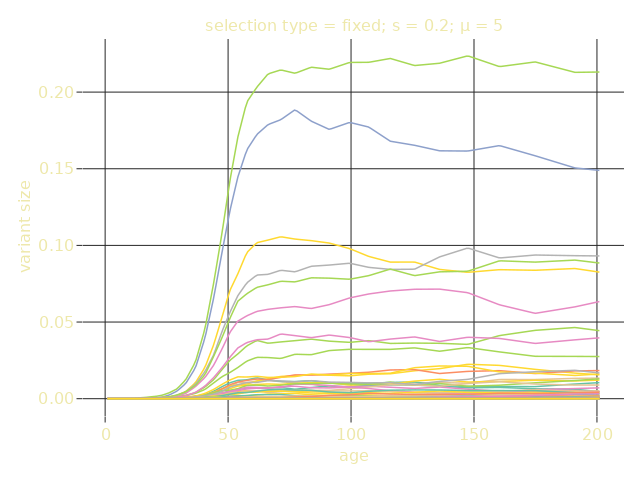

In [27]:
simID = 2
xTot_t = [sum(solEns[simID][t][solEns[simID][t] .> 0.01]) for t in 1:length(solEns[simID])]
fig = Figure()
Axis(
    fig[1,1],
    # yscale=Makie.pseudolog10,
    xlabel="age",
    ylabel="variant size",
    title="selection type = "*paramsPop[:sType]*"; s = "*string(paramsPop[:s])*"; μ = "*string(paramsPop[:μ]),
    # xscale=identity,
)
# ylims!(1E-6, 1)
for i in 1:length(solEns[simID][end])
    lines!([solEns[simID][t][i] for t in 1:length(solEns[simID])])
end
# lines!(xTot_t, color=:black, linestyle=:dash)
display(fig)

We can look at the size distribution of the variants at any timepoint:

In [28]:
_f, nV_t_f = CompetitiveSelection.variantsSizeDistribution(solEns, xMin=0.001, xMax=0.6, bins=100, normalized=true)
sum(nV_t_f[paramsPop[:T], :]);

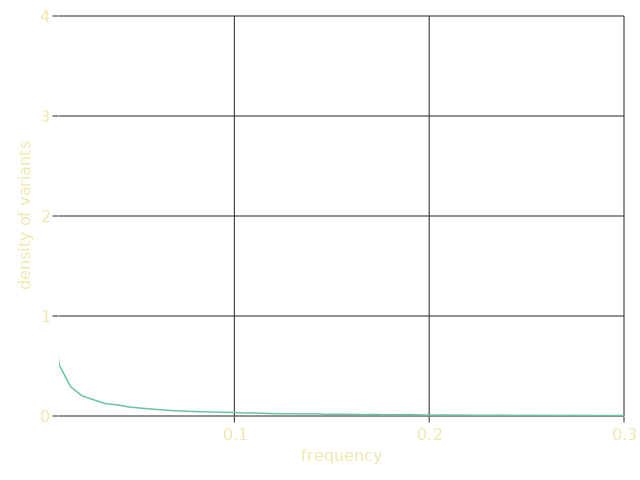

In [29]:
fig2 = Figure()
fig2[1,1] = Axis(fig2[1,1], xlabel="frequency", ylabel="density of variants")
lines!(_f, nV_t_f[end,:])
xlims!(0.01,0.3)
ylims!(0,4)
display(fig2)

As well as the number of detectable variants over time:

In [8]:
nVars_sim_t = Array{Float64}(undef, runs, length(solEns[1]))
for simId in 1:runs
    for tInd in 1:paramsPop[:T]
        detectableVariants_vid = solEns[simId][tInd] .> 0.01
        nVars_sim_t[simId,tInd] = sum(detectableVariants_vid)
    end
end
nVarsAv_t = vec(mean(nVars_sim_t,dims=1));

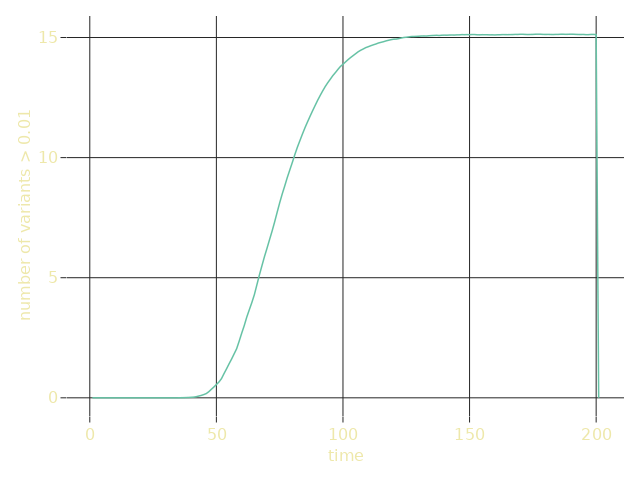

In [9]:
fig3 = Figure()
fig3[1,1] = Axis(fig3[1,1],
    xlabel="time",
    ylabel="number of variants > 0.01",
)
lines!(nVarsAv_t)
# xlims!(0.01,0.3)
# ylims!(0,4)
display(fig3)

To match the simulations, we construct a PDE for the variant distribution from the Fokker-Planck equation with an additional source term:
\begin{equation}
\begin{aligned}
\partial_t n(x,t) &= \mu \, \delta(x - 1/N) \\
&\quad + \partial_x \alpha s\,  x \left( 1 - \int_0^1 x' n(x',t) \, dx' \right) n(x,t) \\
&\quad + \partial_{xx} \frac{\alpha}{2N} x \left( 2 + s + s \int_0^1 x' n(x',t) \, dx' \right) n(x,t)
\end{aligned}
\end{equation}
We compare this with the simulations:

In [47]:
vfs = CompetitiveSelection.VFreqspace(paramsPop[:N], 404, 1)
@time CompetitiveSelection.evolveSizeDist(vfs, paramsPop, paramsPop[:T])
# nSpl = Spline1D(vfs._f, vfs.n_f; k=2)
# quadgk(nSpl, 0,1)[1]

2
2.5e-6
  1.066774 seconds (3.84 M allocations: 172.070 MiB)


402-element view(::Vector{Float64}, 2:403) with eltype Float64:
 164207.44260705286
 166213.79159558009
  36795.49780038045
  15639.033728710867
   8568.863454516972
   5384.503945174476
   3688.1101137949336
   2680.70241691796
   2034.9476662444954
   1596.8038519391353
   1286.146558292552
   1058.0078699505493
    885.5938013693519
      ⋮
      0.319118146144852
      0.6181667907766183
      0.283436791711669
      0.641943409032112
      0.2423777481631903
      0.6718544710604423
      0.1948840726267495
      0.7090472795155679
      0.13969930171677936
      0.7548867694438345
      0.07532982832991195
      0.8109965936686174

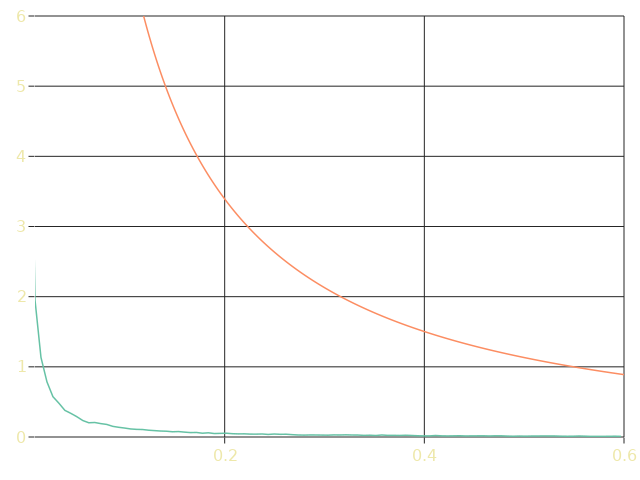

In [53]:
fig2 = Figure()
fig2[1,1] = Axis(fig2[1,1])
lines!(_f, nV_t_f[end,:], label="simulations")
lines!(vfs._f, vfs.n_f, label="PDE")
# xlims!(0.01, 0.1)
# xlims!(0.01,0.2)
xlims!(0.01,0.6)
ylims!(0,6)
# ylims!(0,4)
display(fig2)

Something is wrong...